In [25]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [26]:
import caffe

In [27]:
import os
if os.path.isfile('/home/lebedev/vgg_face_caffe/VGG_FACE.caffemodel'):
    print 'VGG FACE was founded'
else:
    print 'model not found'

VGG FACE was founded


In [28]:
caffe.set_mode_cpu()

model_def = '/home/lebedev/vgg_face_caffe/VGG_FACE_deploy.prototxt'
model_weights = '/home/lebedev/vgg_face_caffe/VGG_FACE.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [29]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load('/home/lebedev/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


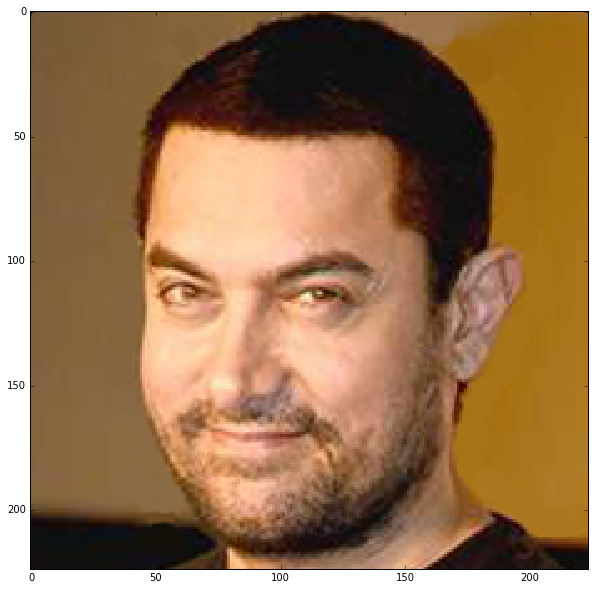

In [30]:
image = caffe.io.load_image('/home/lebedev/vgg_face_caffe/ak.png')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [31]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 2


In [32]:
# load labels
labels_file = '/home/lebedev/vgg_face_caffe/names.txt'
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: Aamir_Khan


In [33]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.95602608, 'Aamir_Khan'),
 (0.0050932118, 'Adam_Driver'),
 (0.0035137327, 'Manish_Dayal'),
 (0.0015653344, 'John_Abraham'),
 (0.0010380425, 'Jacob_Artist')]

For each layer, let's look at the activation shapes, which typically have the form (batch_size, channel_dim, height, width).

In [34]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1_1	(1, 64, 224, 224)
conv1_2	(1, 64, 224, 224)
pool1	(1, 64, 112, 112)
conv2_1	(1, 128, 112, 112)
conv2_2	(1, 128, 112, 112)
pool2	(1, 128, 56, 56)
conv3_1	(1, 256, 56, 56)
conv3_2	(1, 256, 56, 56)
conv3_3	(1, 256, 56, 56)
pool3	(1, 256, 28, 28)
conv4_1	(1, 512, 28, 28)
conv4_2	(1, 512, 28, 28)
conv4_3	(1, 512, 28, 28)
pool4	(1, 512, 14, 14)
conv5_1	(1, 512, 14, 14)
conv5_2	(1, 512, 14, 14)
conv5_3	(1, 512, 14, 14)
pool5	(1, 512, 7, 7)
fc6	(1, 4096)
fc7	(1, 4096)
fc8	(1, 2622)
prob	(1, 2622)


The param shapes typically have the form (output_channels, input_channels, filter_height, filter_width) (for the weights) and the 1-dimensional shape (output_channels,) (for the biases).

In [35]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
conv5_3	(512, 512, 3, 3) (512,)
fc6	(4096, 25088) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(2622, 4096) (2622,)


In [36]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

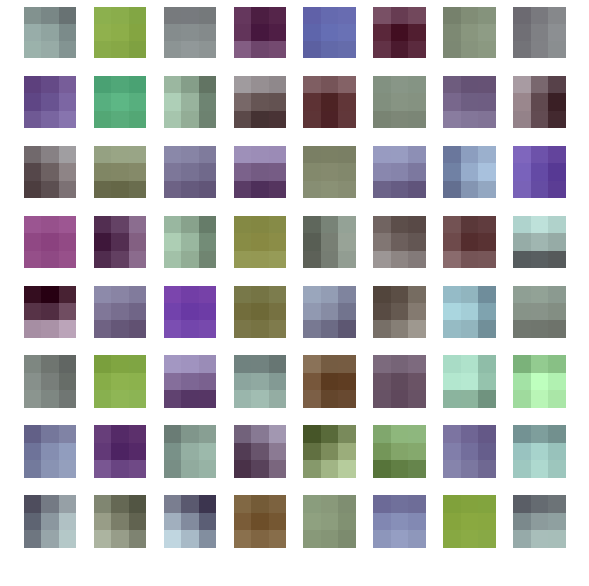

In [37]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

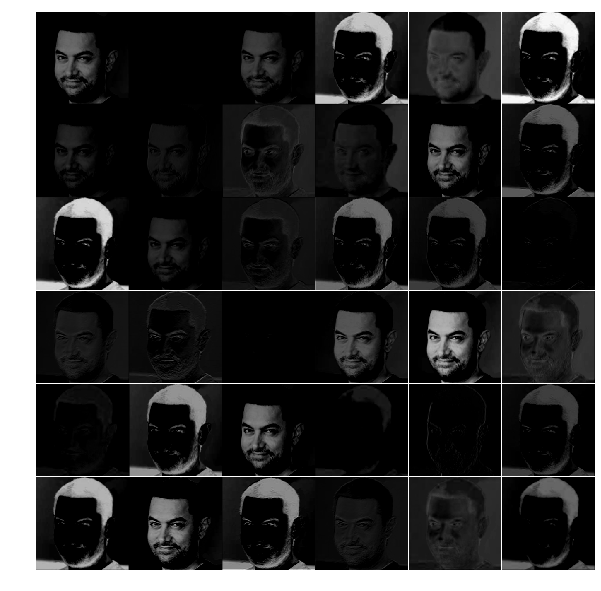

In [49]:
feat = net.blobs['conv1_1'].data[0, :36]
vis_square(feat)

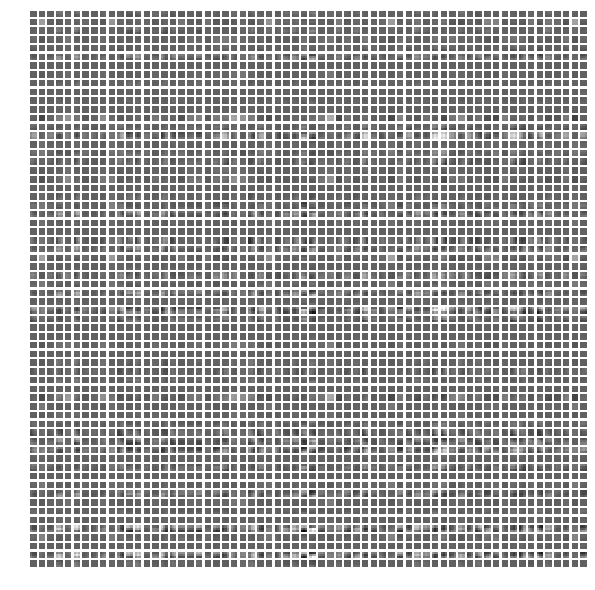

In [64]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_2'][0].data
vis_square(filters.reshape(64**2, 3, 3))

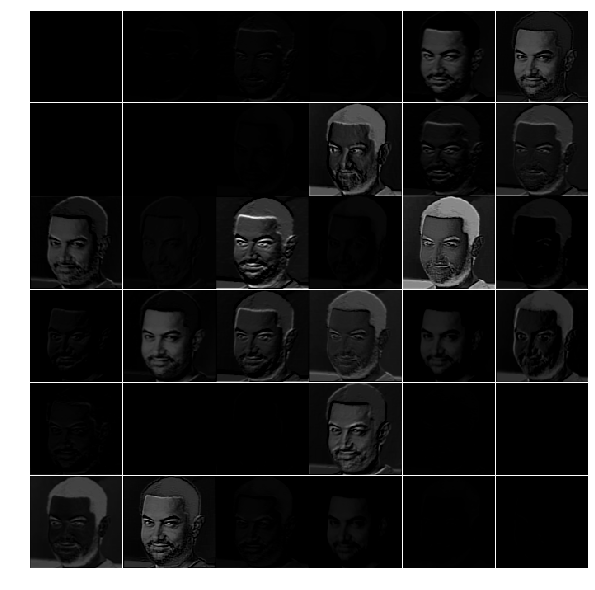

In [54]:
feat = net.blobs['conv2_1'].data[0, :36]
vis_square(feat)

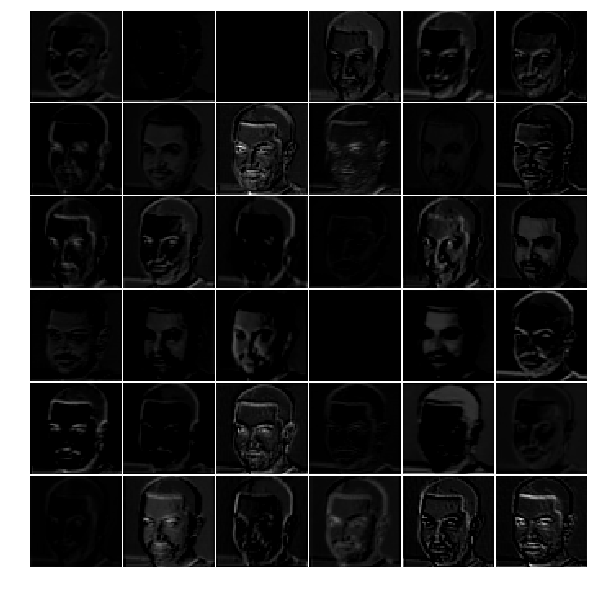

In [55]:
feat = net.blobs['conv3_1'].data[0, :36]
vis_square(feat)

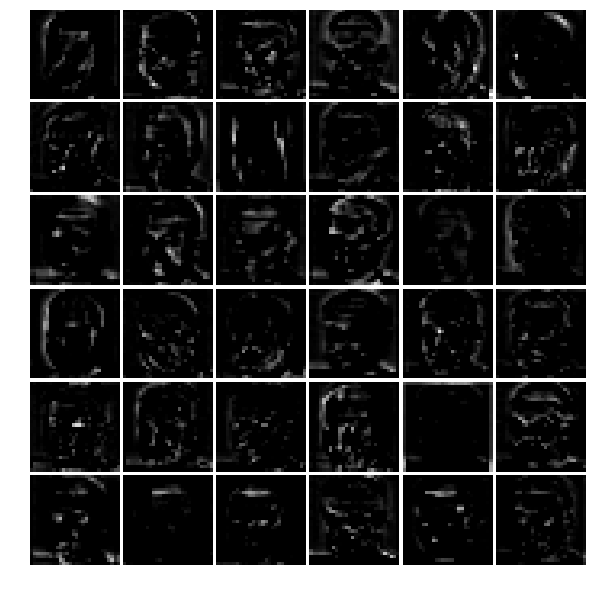

In [57]:
feat = net.blobs['conv4_1'].data[0, :36]
vis_square(feat)

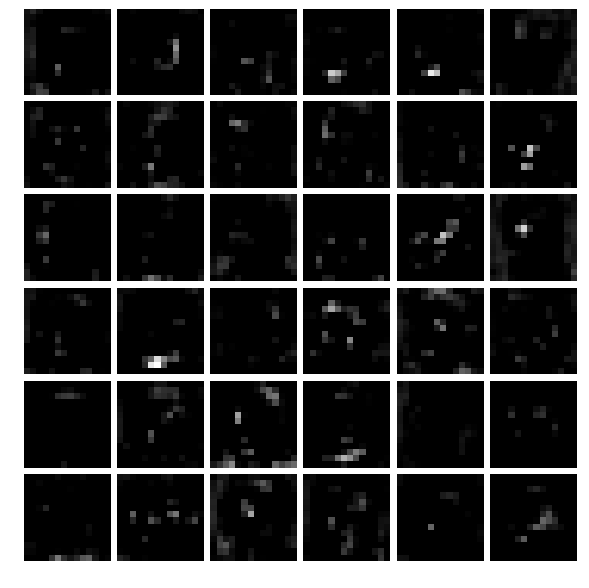

In [58]:
feat = net.blobs['conv5_1'].data[0, :36]
vis_square(feat)

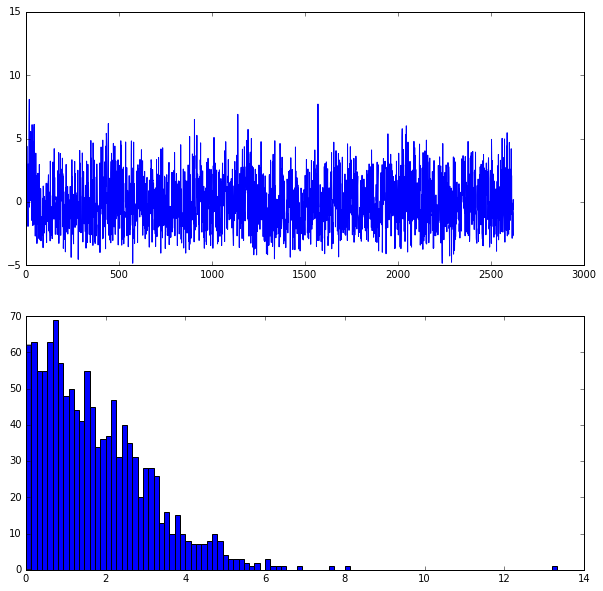

In [17]:
feat = net.blobs['fc8'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

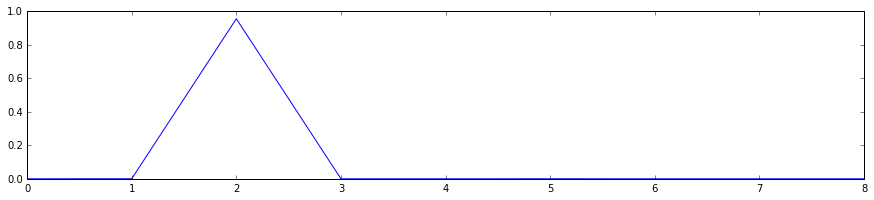

In [26]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.xlim([0,8])
plt.plot(feat.flat)